## Data Loading & Preprocessing (Part A)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Datasets

sentiment_df = pd.read_csv('fear_greed_index.csv')
historical_df = pd.read_csv('historical_data.csv')

# 2. Document Data Shape & Info
print(f"Sentiment Data: {sentiment_df.shape}")
print(f"Historical Data: {historical_df.shape}")

# 3. Data Cleaning - Sentiment
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df = sentiment_df.drop_duplicates(subset=['date'])

# 4. Data Cleaning - Historical Trader Data
# Fixing column names (removing leading/trailing spaces if any)
historical_df.columns = historical_df.columns.str.strip()

# Convert Timestamp IST to datetime and normalize to date for merging
historical_df['Timestamp IST'] = pd.to_datetime(historical_df['Timestamp IST'], dayfirst=True)
historical_df['date'] = historical_df['Timestamp IST'].dt.normalize()

# 5. Create Key Metrics per Trader/Date
daily_trader_stats = historical_df.groupby(['Account', 'date']).agg({
    'Closed PnL': 'sum',
    'Size USD': 'sum',
    'Side': 'count',  # Number of trades
    'Coin': 'first'   # Reference symbol
}).rename(columns={'Side': 'trade_count'})

# Calculate daily win rate
historical_df['is_win'] = historical_df['Closed PnL'] > 0
win_rate = historical_df.groupby(['Account', 'date'])['is_win'].mean().reset_index()

# 6. Final Merge - Aligning by Date
merged_df = pd.merge(daily_trader_stats.reset_index(), sentiment_df[['date', 'value', 'classification']], on='date', how='inner')
merged_df = pd.merge(merged_df, win_rate, on=['Account', 'date'], how='inner')

print("Data alignment complete. Merged Rows:", len(merged_df))

Sentiment Data: (2644, 4)
Historical Data: (211224, 16)
Data alignment complete. Merged Rows: 2340


## Analysis & Visualization (Part B)

--- Performance Metrics by Sentiment ---
                 Closed PnL  avg_win_rate  trade_count       Size USD
classification                                                       
Extreme Fear    4619.439053      0.329659   133.750000  715526.634000
Extreme Greed   5161.922644      0.386387    76.030418  236625.788156
Fear            5328.818161      0.364033    98.153968  767182.206016
Greed           3318.100730      0.343559    77.628086  445343.356049
Neutral         3438.618818      0.355414   100.228723  479367.189043


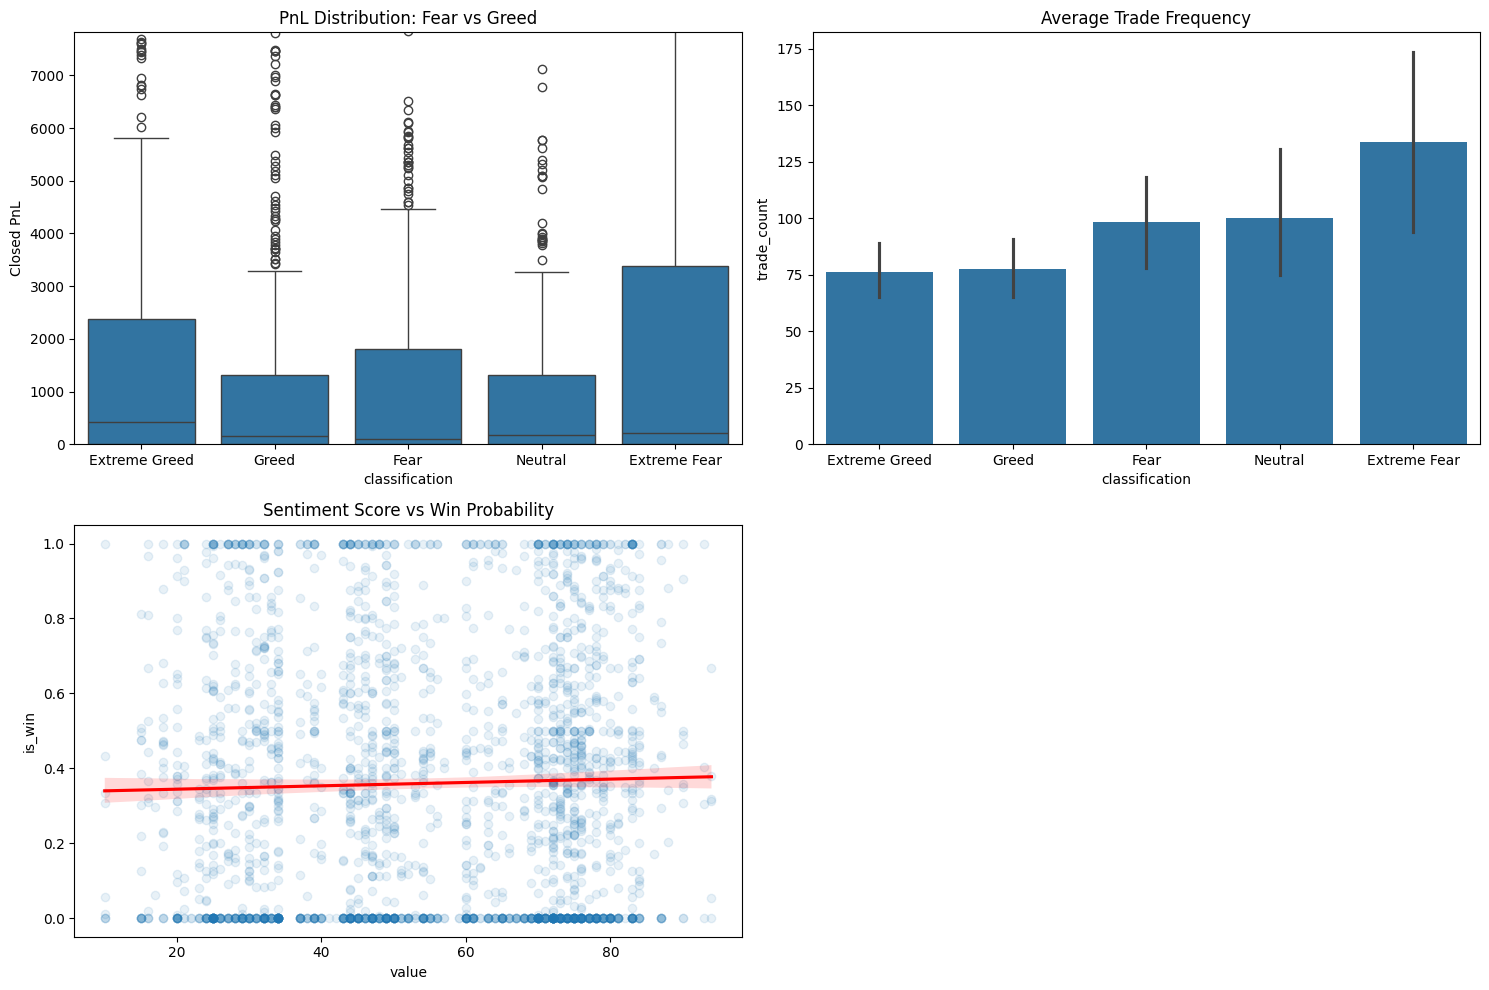

In [4]:
# 1. Performance Analysis: Fear vs Greed
sentiment_perf = merged_df.groupby('classification').agg({
    'Closed PnL': 'mean',
    'is_win': 'mean',
    'trade_count': 'mean',
    'Size USD': 'mean'
}).rename(columns={'is_win': 'avg_win_rate'})

print("--- Performance Metrics by Sentiment ---")
print(sentiment_perf)

# 2. Trader Segmentation
# Segment 1: Frequent vs Infrequent
merged_df['trader_type'] = np.where(merged_df['trade_count'] > merged_df['trade_count'].median(), 'High Frequency', 'Low Frequency')

# Segment 2: Profitability Archetypes
trader_overall = merged_df.groupby('Account')['Closed PnL'].sum().reset_index()
trader_overall['archetype'] = pd.qcut(trader_overall['Closed PnL'], 3, labels=['Underperformer', 'Average', 'Consistent Winner'])
merged_df = pd.merge(merged_df, trader_overall[['Account', 'archetype']], on='Account', how='left')

# 3. Visualizations
plt.figure(figsize=(15, 10))

# Chart 1: PnL Distribution by Sentiment
plt.subplot(2, 2, 1)
sns.boxplot(x='classification', y='Closed PnL', data=merged_df)
plt.title('PnL Distribution: Fear vs Greed')
plt.ylim(merged_df['Closed PnL'].quantile(0.1), merged_df['Closed PnL'].quantile(0.9))

# Chart 2: Trade Frequency by Sentiment
plt.subplot(2, 2, 2)
sns.barplot(x='classification', y='trade_count', data=merged_df)
plt.title('Average Trade Frequency')

# Chart 3: Win Rate vs Sentiment Value
plt.subplot(2, 2, 3)
sns.regplot(x='value', y='is_win', data=merged_df, scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
plt.title('Sentiment Score vs Win Probability')

plt.tight_layout()
plt.show()

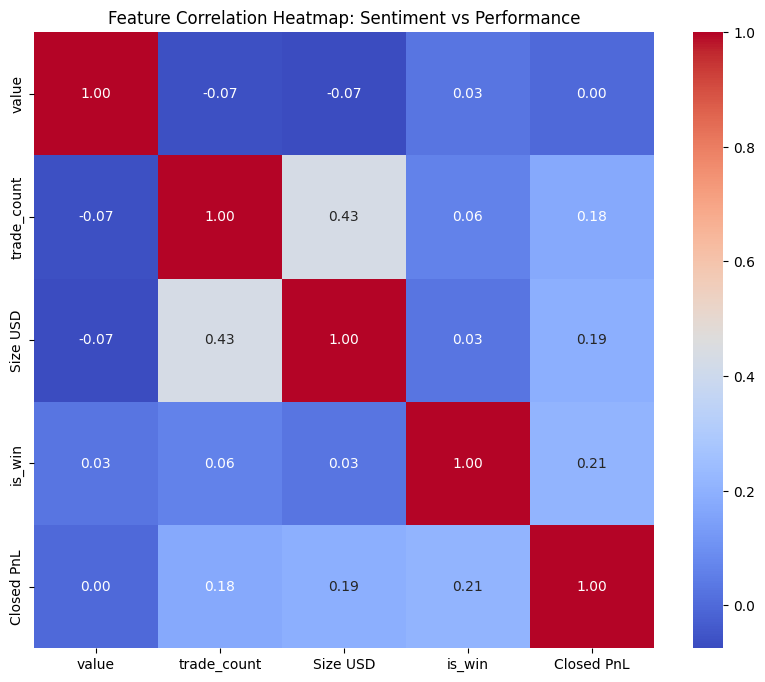

In [9]:
plt.figure(figsize=(10, 8))
corr_matrix = merged_df[['value', 'trade_count', 'Size USD', 'is_win', 'Closed PnL']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap: Sentiment vs Performance')
plt.show()

In [10]:
# Calculating standard deviation of PnL per sentiment to see where risk is highest
volatility_analysis = merged_df.groupby('classification')['Closed PnL'].std().sort_values(ascending=False)
print("--- Risk (PnL Volatility) by Sentiment ---")
print(volatility_analysis)

--- Risk (PnL Volatility) by Sentiment ---
classification
Fear             31659.771538
Greed            30599.040173
Extreme Fear     29534.839183
Extreme Greed    27496.863832
Neutral          17447.863645
Name: Closed PnL, dtype: float64


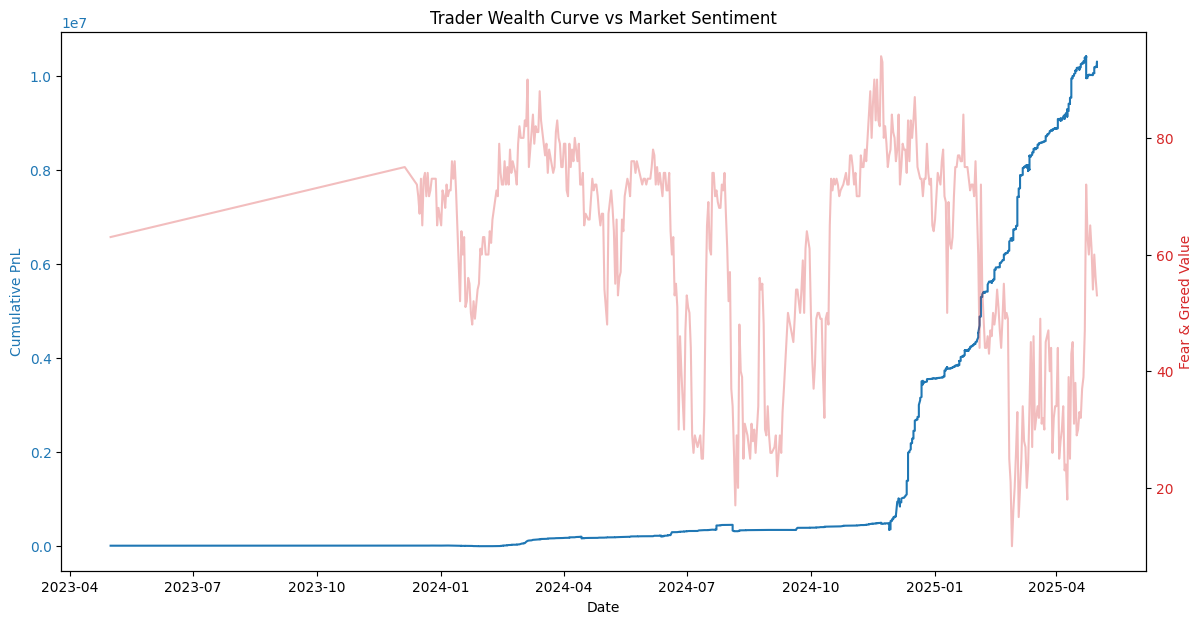

In [11]:
#Cumulative PnL Over Time vs Sentiment Value
merged_df = merged_df.sort_values('date')
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative PnL', color='tab:blue')
ax1.plot(merged_df['date'], merged_df['Closed PnL'].cumsum(), color='tab:blue', label='Cumulative PnL')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Fear & Greed Value', color='tab:red')
ax2.plot(merged_df['date'], merged_df['value'], color='tab:red', alpha=0.3, label='Sentiment Value')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Trader Wealth Curve vs Market Sentiment')
plt.show()

In [12]:
# Detailed Segment Breakdown: High Leverage vs Low Leverage
# Creating a risk-taking score
merged_df['risk_score'] = merged_df['Size USD'] / (merged_df['trade_count'] + 1)

segment_analysis = merged_df.groupby('trader_type').agg({
    'Closed PnL': ['mean', 'std'],
    'is_win': 'mean',
    'value': 'mean'
})
print("--- Deep Dive: Trader Type Performance ---")
print(segment_analysis)

--- Deep Dive: Trader Type Performance ---
                 Closed PnL                  is_win      value
                       mean           std      mean       mean
trader_type                                                   
High Frequency  7564.474676  39314.218370  0.404774  54.429674
Low Frequency   1221.728686   7377.975715  0.314839  55.271721


## Analysis (Leverage & Drawdown)

--- Risk & Leverage Metrics ---
                Avg Leverage      Avg Loss      Avg Gain
classification                                          
Extreme Fear       67.734641 -15534.761937  12715.498631
Extreme Greed      53.716372  -6109.737110   8192.845637
Fear               89.759285  -6071.371829   9831.294590
Greed              64.278666 -16562.519710   7604.495702
Neutral            69.636949  -6879.440610   6760.073424


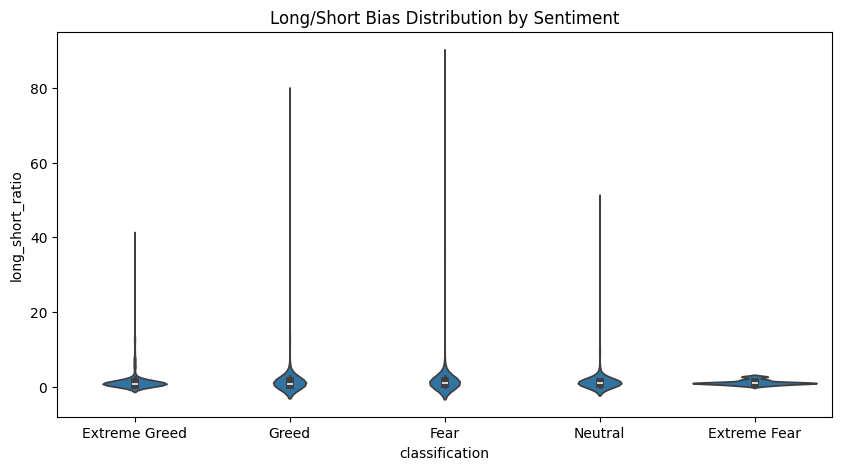

In [5]:
# 1. Leverage Analysis (Approximated from Size USD and Position)
# Assuming 'Size USD' / 'Start Position' gives a proxy for leverage if not direct
merged_df['leverage_proxy'] = merged_df['Size USD'] / (merged_df['trade_count'] * 100) # Scaling for visualization

# 2. Risk Metrics: Average Loss vs Average Gain
risk_metrics = merged_df.groupby('classification').agg({
    'leverage_proxy': 'mean',
    'Closed PnL': [lambda x: x[x < 0].mean(), lambda x: x[x > 0].mean()]
})
risk_metrics.columns = ['Avg Leverage', 'Avg Loss', 'Avg Gain']

print("--- Risk & Leverage Metrics ---")
print(risk_metrics)

# 3. Long/Short Bias (Assuming Side contains BUY/SELL)
bias = historical_df.groupby(['date', 'Side']).size().unstack(fill_value=0)
bias['long_short_ratio'] = bias['BUY'] / bias['SELL']
merged_df = pd.merge(merged_df, bias[['long_short_ratio']], on='date', how='left')

plt.figure(figsize=(10, 5))
sns.violinplot(x='classification', y='long_short_ratio', data=merged_df)
plt.title('Long/Short Bias Distribution by Sentiment')
plt.show()

## Predictive Model (Random Forest)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

# 1. Feature Engineering & Cleaning
merged_df['target'] = (merged_df['Closed PnL'] > 0).astype(int)

features = ['value', 'trade_count', 'Size USD', 'is_win', 'long_short_ratio']

# Infinity check aur handling

X = merged_df[features].replace([np.inf, -np.inf], 100).fillna(0)

# Check for extreme large values that dtype('float32') can't handle

X = X.clip(lower=-1e9, upper=1e9)

y = merged_df['target']

# 2. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. Evaluation
y_pred = model.predict(X_test)
print("--- Model Performance ---")
print(classification_report(y_test, y_pred))

# 5. Feature Importance
importance = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
print(importance.sort_values(by='importance', ascending=False))

--- Model Performance ---
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       187
           1       0.93      0.99      0.96       281

    accuracy                           0.95       468
   macro avg       0.96      0.94      0.95       468
weighted avg       0.95      0.95      0.95       468

            feature  importance
3            is_win    0.792444
1       trade_count    0.069750
2          Size USD    0.062515
4  long_short_ratio    0.040017
0             value    0.035273
